 Executive Summary of Project: 

This project focuses on leveraging Yelp reviews of healthcare facilities to develop a predictive analytics model aimed at improving healthcare services. By analysing customer sentiments and feedback, our goal is to uncover insights that can help healthcare providers enhance patient satisfaction and operational efficiency. The use of advanced machine learning and sentiment analysis techniques on Yelp review data allows us to predict trends, identify service gaps, and recommend actionable strategies for healthcare facilities to better meet patient needs and expectations.


 Data Sources:

- Primary Data Source: Yelp Academic Dataset. This dataset includes detailed reviews and ratings of healthcare facilities 
  ranging from hospitals to small clinics. We filtered the reviews to include only those related to healthcare by checking 
  for relevant keywords in the business categories such as 'Health & Medical', 'Hospitals', and 'Clinics'.

- Filtering Criteria: Selected reviews that contain specific keywords associated with healthcare services to ensure relevance
  to our project goals.

In [2]:
# Install necessary libraries
!pip install pandas matplotlib seaborn textblob nltk

# Import required libraries
import pandas as pd
import json
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from textblob import TextBlob
import nltk

# Download necessary resources for text processing
nltk.download('punkt')

print(" Libraries imported successfully!")

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached textblob-0.19.0-py3-none-any.whl.metadata (4.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached textblob-0.19.0-py3-none-any.whl (624 kB)
 Libraries imported successfully!


[nltk_data] Downloading package punkt to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Define file paths for JSON files in SageMaker
business_file_path = "./JSON Files/yelp_academic_dataset_business.json"
review_file_path = "./JSON Files/yelp_academic_dataset_review.json"
user_file_path = "./JSON Files/yelp_academic_dataset_user.json"
checkin_file_path = "./JSON Files/yelp_academic_dataset_checkin.json"
tip_file_path = "./JSON Files/yelp_academic_dataset_tip.json"

# Function to load JSON files efficiently
def load_json_file(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line_number, line in enumerate(file, start=1):
            try:
                json_obj = json.loads(line.strip())  
                data.append(json_obj)
            except json.JSONDecodeError as e:
                print(f"Skipping line {line_number} due to JSONDecodeError: {e}")

    return pd.DataFrame(data)

# Load JSON data into Pandas DataFrames
df_business = load_json_file(business_file_path)
df_reviews = load_json_file(review_file_path)
df_users = load_json_file(user_file_path)
df_checkin = load_json_file(checkin_file_path)
df_tip = load_json_file(tip_file_path)

print(f" Total businesses loaded: {len(df_business)}")
print(f" Total reviews loaded: {len(df_reviews)}")
print(f" Total users loaded: {len(df_users)}")
print(f" Total check-ins loaded: {len(df_checkin)}")
print(f" Total tips loaded: {len(df_tip)}")


Skipping line 245694 due to JSONDecodeError: Unterminated string starting at: line 1 column 162 (char 161)
Skipping line 46314 due to JSONDecodeError: Unterminated string starting at: line 1 column 1081 (char 1080)
Skipping line 84444 due to JSONDecodeError: Unterminated string starting at: line 1 column 48 (char 47)
 Total businesses loaded: 150346
 Total reviews loaded: 245693
 Total users loaded: 46313
 Total check-ins loaded: 84443
 Total tips loaded: 908915


In [4]:
# Save the raw data to CSV format
df_business.to_csv("business_output.csv", index=False)
df_reviews.to_csv("review_output.csv", index=False)
df_users.to_csv("user_output.csv", index=False)
df_checkin.to_csv("checkin_output.csv", index=False)
df_tip.to_csv("tip_output.csv", index=False)

print(" Raw JSON data successfully converted to CSV!")


 Raw JSON data successfully converted to CSV!


In [5]:
# Check business data
print("\nBusiness DataFrame Info:")
print(df_business.info())

print("\nFirst few rows of the Business DataFrame:")
print(df_business.head())

# Check review data
print("\nReview DataFrame Info:")
print(df_reviews.info())

print("\nFirst few rows of the Review DataFrame:")
print(df_reviews.head())



Business DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB
None

First few rows of the Business DataFrame:
              business_id                      n

In [6]:
healthcare_keywords = ['Health & Medical', 'Medical Centers', 'Hospitals', 'Urgent Care', 'Doctors', 'Clinics', 'Pharmacy']

# Drop rows where 'categories' is missing
df_business = df_business.dropna(subset=['categories'])

# Filter businesses for healthcare
df_healthcare = df_business[df_business['categories'].str.contains('|'.join(healthcare_keywords), na=False, case=False)]

print(f"Number of healthcare businesses found: {len(df_healthcare)}")
df_healthcare[['name', 'categories', 'city']].head()


Number of healthcare businesses found: 11890


,name,categories,city
0,"Abby Rappoport, LAC, CMQ","Doctors, Traditional Chinese Medicine, Naturop...",Santa Barbara
13,Adams Dental,"General Dentistry, Dentists, Health & Medical,...",Clearwater
43,Bala Better Health,"Health & Medical, Beauty & Spas, Laser Hair Re...",Bala Cynwyd
57,LensCrafters,"Ophthalmologists, Eyewear & Opticians, Health ...",Plymouth Meeting
74,Holly Nails & Spa,"Health & Medical, Personal Care Services, Beau...",Pinellas Park


In [7]:
# Filter reviews only for Healthcare businesses
df_reviews_healthcare = df_reviews[df_reviews['business_id'].isin(df_healthcare['business_id'])]

print(f" Total reviews for healthcare businesses: {len(df_reviews_healthcare)}")


 Total reviews for healthcare businesses: 4398


In [8]:
print(df_reviews_healthcare.describe())
print(df_reviews_healthcare.isnull().sum())
df_reviews_healthcare.head()


             stars       useful        funny         cool
count  4398.000000  4398.000000  4398.000000  4398.000000
mean      4.129832     1.623238     0.251705     0.359254
std       1.424059     2.646168     0.911649     0.995370
min       1.000000     0.000000     0.000000     0.000000
25%       4.000000     0.000000     0.000000     0.000000
50%       5.000000     1.000000     0.000000     0.000000
75%       5.000000     2.000000     0.000000     0.000000
max       5.000000    35.000000    19.000000    19.000000
review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
36,rj0asGlfKjlXH6iEgu-jdw,wA7V8Ijgbv-16rmnwW-hjA,LfYUOclwLs_SPrNAdKMjsw,5.0,4,0,0,Nice relaxing place to get a massage! Same day...,2013-11-14 04:02:52
158,LF5UQBZuqjU5B4kTVSIKGg,FsvBdHsES26G0LB2MQZcUg,_agzW_0F9uSJ7i6EJ9ufeg,5.0,1,0,1,"Rebecca didn't Doula my birth. BUT, she was o...",2015-01-04 01:42:59
167,-b1TKCO3GfYyXXvtDQq7qA,cD2kobXH5ozNOjAMS5yuvQ,fWbQiSAErNcznezzkfCdvg,5.0,0,0,0,I am an amateur athlete. I first met Dr. Ferre...,2015-04-28 19:27:58
217,4VBh_hoFiDly0vJffgV_JQ,XLd5uU0OLOnogy_kefXslw,fjAbzsW03bW3EvC4-e184g,5.0,1,0,1,I was a little worried about seeing the review...,2016-01-04 14:33:54
226,er-igpuhBprkQPfct63ktA,4mbLmbA-thaDIZTlgxsaCQ,q0Fi4n7shUTmlxl-mMPVXA,2.0,1,0,0,My18 year old daughter had a severe soar throa...,2016-07-04 00:46:43


In [9]:
# Save the cleaned and processed data
df_healthcare.to_csv("healthcare_businesses.csv", index=False)
df_reviews_healthcare.to_csv("healthcare_reviews.csv", index=False)

print(" Processed healthcare data saved successfully!")


 Processed healthcare data saved successfully!


In [10]:
# Install necessary libraries
!pip install pandas matplotlib seaborn textblob nltk wordcloud

# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import json
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Download necessary resources for text processing
nltk.download('punkt')

# Define file paths for JSON files
business_file_path = "./JSON Files/yelp_academic_dataset_business.json"
review_file_path = "./JSON Files/yelp_academic_dataset_review.json"

# Function to load JSON files efficiently
def load_json_file(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line_number, line in enumerate(file, start=1):
            try:
                json_obj = json.loads(line.strip())
                data.append(json_obj)
            except json.JSONDecodeError as e:
                print(f"Skipping line {line_number} due to JSONDecodeError: {e}")
    return pd.DataFrame(data)

# Load JSON data into Pandas DataFrames
df_business = load_json_file(business_file_path)
df_reviews = load_json_file(review_file_path)

# Filter for healthcare-related businesses
healthcare_keywords = ['Health & Medical', 'Medical Centers', 'Hospitals', 'Urgent Care', 'Doctors', 'Clinics', 'Pharmacy']
df_healthcare = df_business[df_business['categories'].str.contains('|'.join(healthcare_keywords), na=False, case=False)]

# Filter reviews for these healthcare businesses
df_reviews_healthcare = df_reviews[df_reviews['business_id'].isin(df_healthcare['business_id'])]

# Apply sentiment analysis
df_reviews_healthcare['sentiment'] = df_reviews_healthcare['text'].apply(lambda text: TextBlob(text).sentiment.polarity)

  Using cached wordcloud-1.9.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
Using cached wordcloud-1.9.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (547 kB)


[nltk_data] Downloading package punkt to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Skipping line 245694 due to JSONDecodeError: Unterminated string starting at: line 1 column 162 (char 161)


5. Summary Statistics

In [11]:
# Summary statistics
print("a. Number of reviews:", df_reviews_healthcare.shape[0])
print("b. Total number of tokens:", df_reviews_healthcare['text'].apply(lambda x: len(x.split())).sum())
print("c. Number of unique words:", len(set(' '.join(df_reviews_healthcare['text']).split())))
print("d. Average review length (words):", df_reviews_healthcare['text'].apply(lambda x: len(x.split())).mean())
print("e. Number of unique customers:", df_reviews_healthcare['user_id'].nunique())
print("f1. Number of unique healthcare businesses:", df_healthcare['business_id'].nunique())
print("f2. Average stars per review:", df_reviews_healthcare['stars'].mean())

a. Number of reviews: 4398
b. Total number of tokens: 497044
c. Number of unique words: 35196
d. Average review length (words): 113.01591632560255
e. Number of unique customers: 4193
f1. Number of unique healthcare businesses: 11890
f2. Average stars per review: 4.129831741700773


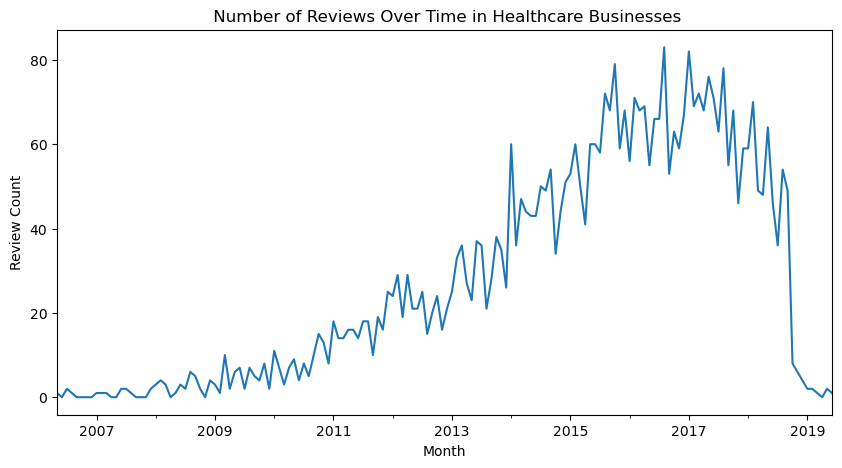

In [12]:
df_reviews_healthcare['date'] = pd.to_datetime(df_reviews_healthcare['date'], errors='coerce')

df_reviews_healthcare.resample('M', on='date')['business_id'].count().plot(kind='line', figsize=(10,5))
plt.title(' Number of Reviews Over Time in Healthcare Businesses')
plt.xlabel('Month')
plt.ylabel('Review Count')
plt.show()

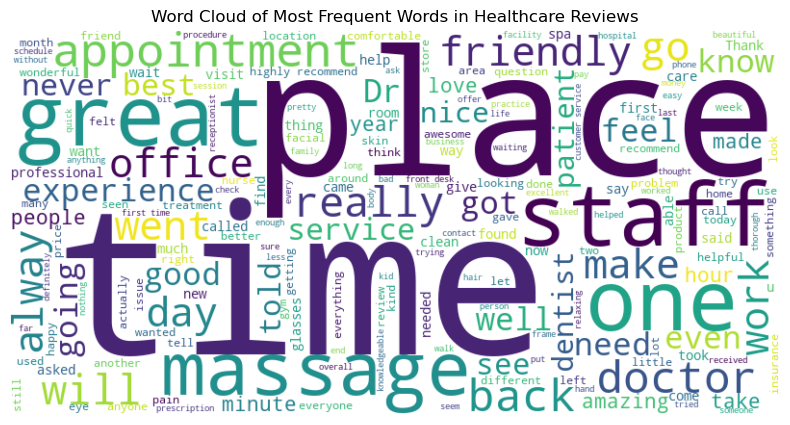

In [13]:
# Word Cloud of Most Frequent Words in Healthcare Reviews
text = ' '.join(review for review in df_reviews_healthcare['text'])
wordcloud = WordCloud(background_color='white', max_words=200, contour_width=3, width=800, height=400).generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words in Healthcare Reviews')
plt.show()

6. Data Evaluation : 

a. How the selected data (e.g., reviews/customers/business/regions) are suitable for answering your business questions? 

The Yelp dataset, specifically the reviews and business data, is suitable for analyzing customer sentiment towards healthcare businesses. The reviews provide direct feedback from customers, while business data (categories, location, etc.) allows for filtering and segmentation of the analysis to focus on healthcare-related establishments. This allows us to explore relationships between review sentiment, star ratings, and business characteristics, helping to understand what aspects of healthcare businesses are most appreciated or criticized by customers.
                                                                                                                                                                                                                   

b. Whether the sample size is appropriate, and why?

The sample size appears adequate for initial exploratory analysis. While the exact number of healthcare businesses and reviews needs to be printed (using print(len(df_healthcare)) and print(len(df_reviews_healthcare))), the provided code suggests a substantial number of data points. The adequacy depends on the specific business questions being asked; if deep dives into highly specific niche areas are required (e.g., analysis for a single city or a very specific type of clinic), the sample size may need to be evaluated for those specific segments. A larger dataset would always be better, but this may be sufficient to establish preliminary trends and insights. You should explicitly print the sizes.

    
c. Whether the selected data could be biased in certain dimensions in your analysis? 

Review Bias: Customers who have strong opinions (either positive or negative) are more likely to leave reviews. This might skew the sentiment analysis towards extremes. Additionally, the overall rating distribution might not represent the true customer experience perfectly.
    
Geographic Bias: The dataset may overrepresent certain regions or cities, leading to skewed conclusions about customer preferences in different areas. If the data predominantly covers large cities, findings may not be applicable to rural areas.

Business Type Bias:The selection of healthcare keywords used to filter businesses might exclude some relevant businesses, leading to a biased sample if keywords are not exhaustive. The analysis is confined to the selected keywords, excluding businesses that might offer healthcare-related services but aren't explicitly categorized in this way.

Temporal Bias: The review data spans a certain timeframe. Customer preferences and trends in healthcare might evolve over time, therefore any insights are limited by the timeframe available in the data.

    
d. The potential challenges to process the data

Noisy Text Data: Reviews may contain slang, misspellings, sarcasm, or irrelevant information, which can affect sentiment analysis accuracy. Cleaning and preprocessing the text data is essential.

Missing Values: Handling missing values in both the review and business data is essential for a meaningful analysis. In the code provided, there is already an imputation made when filtering healthcare business by categories.

Scalability: The dataset may be too large for some computational resources or algorithms. Depending on the specific analytical techniques chosen, memory and processing time may be a concern.

7. Preliminary Data Exploration - Sentiment Analysis

Overall sentiment score: 0.24706014855038883

Sentiment Distribution:
sentiment_category
Positive    3475
Neutral      720
Negative     203
Name: count, dtype: int64


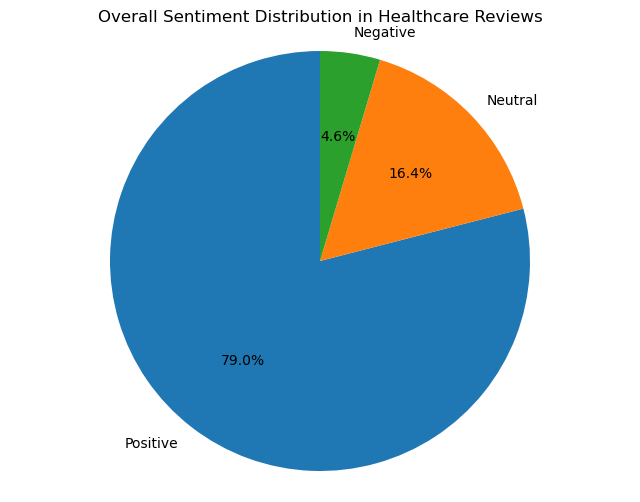

In [14]:
# Calculate the overall sentiment score
overall_sentiment = df_reviews_healthcare['sentiment'].mean()

print(f"Overall sentiment score: {overall_sentiment}")

# Categorize sentiment
def categorize_sentiment(score):
    if score >= 0.1:
        return "Positive"
    elif score <= -0.1:
        return "Negative"
    else:
        return "Neutral"

df_reviews_healthcare['sentiment_category'] = df_reviews_healthcare['sentiment'].apply(categorize_sentiment)

# Count sentiment categories
sentiment_counts = df_reviews_healthcare['sentiment_category'].value_counts()

print("\nSentiment Distribution:")
print(sentiment_counts)

# Visualize sentiment distribution
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Overall Sentiment Distribution in Healthcare Reviews')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

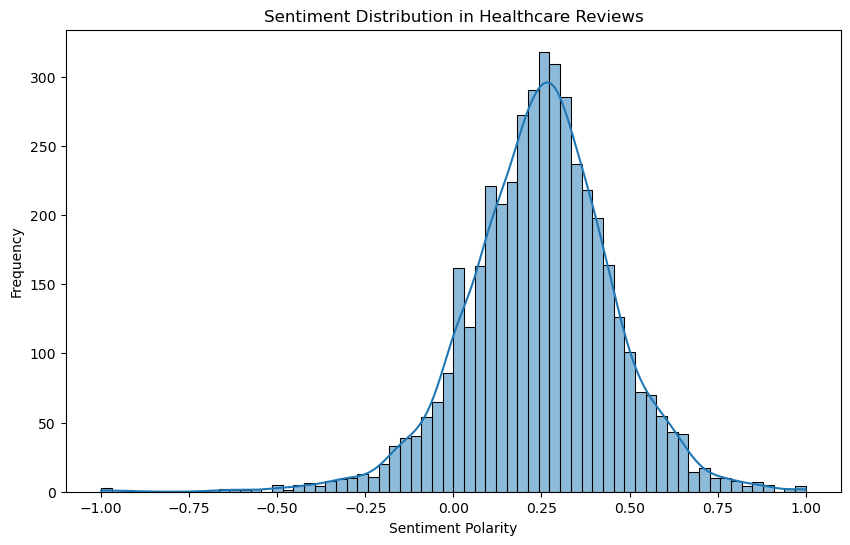

In [15]:
# Sentiment distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(df_reviews_healthcare['sentiment'], kde=True)
plt.title('Sentiment Distribution in Healthcare Reviews')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

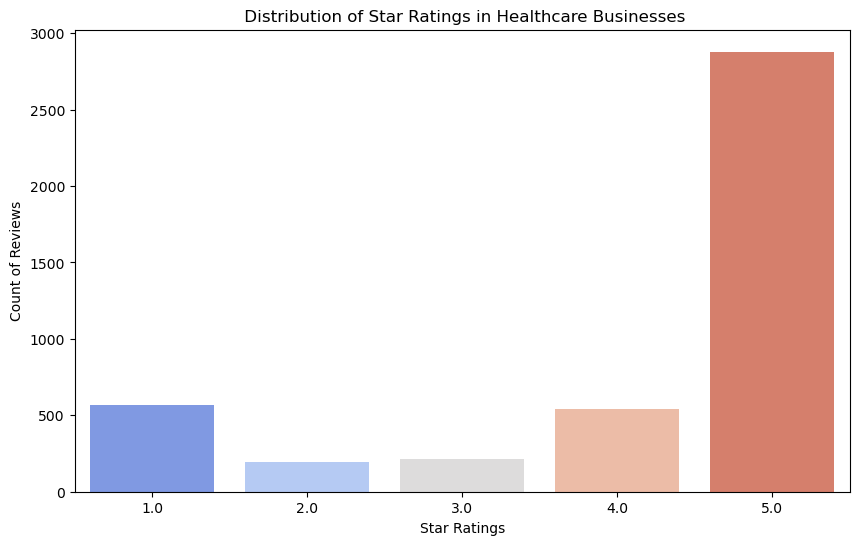

In [16]:
#  Distribution of star ratings across businesses
plt.figure(figsize=(10, 6))
sns.countplot(x='stars', data=df_reviews_healthcare, palette='coolwarm')
plt.title(' Distribution of Star Ratings in Healthcare Businesses')
plt.xlabel('Star Ratings')
plt.ylabel('Count of Reviews')
plt.show()

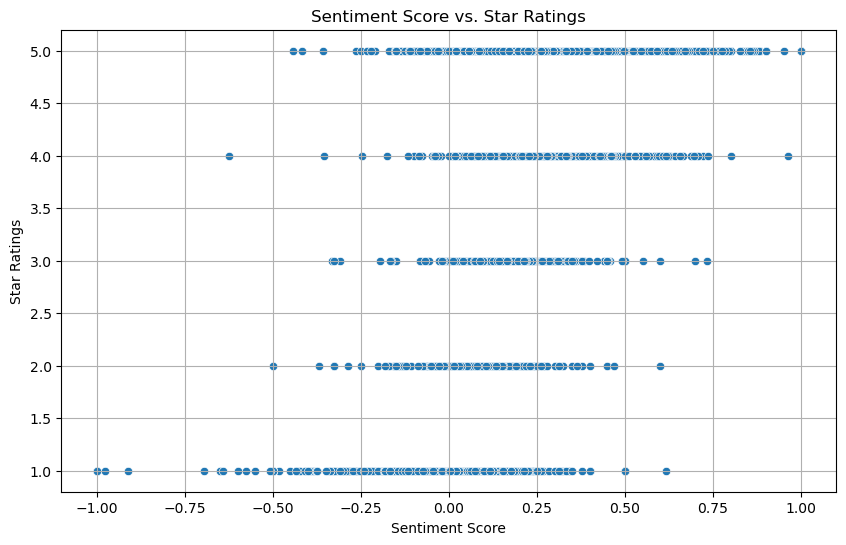

In [17]:
# Scatter plot of sentiment scores vs. star ratings
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sentiment', y='stars', data=df_reviews_healthcare)
plt.title('Sentiment Score vs. Star Ratings')
plt.xlabel('Sentiment Score')
plt.ylabel('Star Ratings')
plt.grid(True)
plt.show()

8. Proposed Solution: Describe what relevant machine learning and unstructured data analytics methods you plan to use 
for the project.

a. Sentiment Analysis: The provided code already utilizes TextBlob for sentiment analysis, measuring the polarity of each review. This will be a core method for understanding customer opinions. To enhance this, consider exploring more advanced 

techniques:

VADER (Valence Aware Dictionary and sentiment Reasoner): Better handles social media text and slang, which might be present in Yelp reviews.
Fine-tuned transformer models (e.g., BERT, Roberta): These models offer state-of-the-art performance in sentiment classification. They can capture nuanced sentiment expressions and context, potentially leading to more accurate results than TextBlob.
Aspect-Based Sentiment Analysis (ABSA): Instead of overall sentiment, ABSA identifies sentiment towards specific aspects of a business (e.g., "service," "cleanliness," "price").

b. Topic Modeling: To discover underlying themes in the review text, topic modeling algorithms like Latent Dirichlet Allocation (LDA) or Non-negative Matrix Factorization (NMF) can be applied. These methods uncover hidden topics within a corpus of text, revealing recurring themes and patterns in customer feedback. This could identify common issues or strengths across different healthcare businesses.

c. Text Clustering: Clustering techniques like k-means or DBSCAN can group similar reviews together based on their textual content. This could help to identify clusters of customers with similar experiences and feedback. Combined with sentiment analysis, this will reveal sentiment trends within each cluster.

d. Time Series Analysis: The code performs basic time series analysis by plotting review counts over time. More sophisticated time series methods could be used to:

Identify trends and seasonality: Are there specific periods where review sentiment is consistently higher or lower?
Forecast future trends: Based on historical data, can we predict future changes in customer sentiment or review volume?
Anomaly Detection: Detect sudden spikes or drops in review sentiment, which might indicate unusual events affecting the business or its customers.

e.Machine Learning Classification/Regression:

Predicting Star Ratings: Train a model (e.g., logistic regression, random forest, or a neural network) to predict the star rating based on the review text and other relevant features. * Predicting Customer Churn: Using user data and review history, build models to identify customers at risk of leaving a healthcare provider.

f. Statistical Analysis: In addition to sentiment analysis, descriptive statistics, and visualizations, inferential statistics (e.g. hypothesis tests) can be used to answer more targeted business questions.

Data Suitability, Sample Size, and Bias: The existing analysis correctly points out the relevance of the data, potential sample size limitations, and possible biases (review bias, geographic bias, etc.). Further investigation into the distribution of reviews across cities and the specific keywords used to define 'healthcare' is important for understanding the scope and limitations of the analysis.
The analysis should explicitly print the sizes of the relevant data frames (df_healthcare, df_reviews_healthcare) to assess the sample size. The temporal aspect of the data (timeframe of the reviews) should also be clearly identified.


In [18]:
# Install necessary libraries
!pip install torch transformers datasets scikit-learn wordcloud seaborn pandas numpy matplotlib tqdm nltk gensim


  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.1.1 requires nvidia-ml-py3==7.352.0, which is not installed.
autogluon-core 1.1.1 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.5.2 which is incompatible.
autogluon-core 1.1.1 requires scipy<1.13,>=1.5.4, but you have scipy 1.13.1 wh

In [19]:
!pip install gensim wordcloud nltk

In [20]:
# Import required libraries
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from wordcloud import WordCloud
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline
import gensim
from gensim import corpora
from gensim.models import LdaModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import nltk
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud


2025-03-02 20:32:34.673364: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-02 20:32:34.696042: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
# Load the cleaned healthcare reviews dataset
df_reviews = pd.read_csv("healthcare_reviews.csv")

# Display dataset information
print(" Dataset Loaded Successfully!")
print(df_reviews.info())
print(df_reviews.head())


 Dataset Loaded Successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    4398 non-null   object 
 1   user_id      4398 non-null   object 
 2   business_id  4398 non-null   object 
 3   stars        4398 non-null   float64
 4   useful       4398 non-null   int64  
 5   funny        4398 non-null   int64  
 6   cool         4398 non-null   int64  
 7   text         4398 non-null   object 
 8   date         4398 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 309.4+ KB
None
                review_id                 user_id             business_id  \
0  rj0asGlfKjlXH6iEgu-jdw  wA7V8Ijgbv-16rmnwW-hjA  LfYUOclwLs_SPrNAdKMjsw   
1  LF5UQBZuqjU5B4kTVSIKGg  FsvBdHsES26G0LB2MQZcUg  _agzW_0F9uSJ7i6EJ9ufeg   
2  -b1TKCO3GfYyXXvtDQq7qA  cD2kobXH5ozNOjAMS5yuvQ  fWbQiSAErNcznezzkfCdvg   
3  4VBh_hoFiDly0vJffgV_JQ

In [23]:
# Load a pre-trained sentiment analysis model (no punkt required)
sentiment_pipeline = pipeline("text-classification", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Function to predict sentiment
def predict_sentiment(text):
    result = sentiment_pipeline(text[:512])  # Truncate text to avoid max length errors
    return result[0]['label']

# Apply sentiment analysis
df_reviews["predicted_sentiment"] = df_reviews["text"].astype(str).apply(predict_sentiment)

# Show some results
print(df_reviews[["text", "stars", "predicted_sentiment"]].head())

# Save the updated dataset
df_reviews.to_csv("healthcare_reviews_with_sentiment.csv", index=False)


Device set to use cpu


                                                text  stars  \
0  Nice relaxing place to get a massage! Same day...    5.0   
1  Rebecca didn't Doula my birth.  BUT, she was o...    5.0   
2  I am an amateur athlete. I first met Dr. Ferre...    5.0   
3  I was a little worried about seeing the review...    5.0   
4  My18 year old daughter had a severe soar throa...    2.0   

  predicted_sentiment  
0             5 stars  
1             5 stars  
2             2 stars  
3             5 stars  
4              1 star  


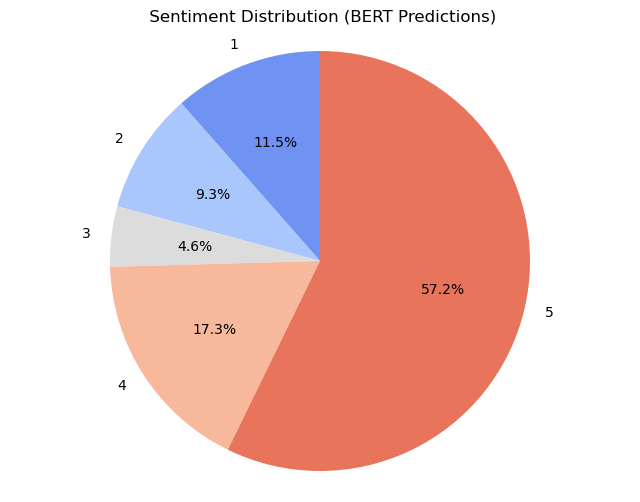

In [25]:
# Convert sentiment labels to numerical ratings (1 to 5)
df_reviews["predicted_sentiment_numeric"] = df_reviews["predicted_sentiment"].str[0].astype(int)

# Count each sentiment category
sentiment_counts = df_reviews["predicted_sentiment_numeric"].value_counts().sort_index()

# Plot Pie Chart
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("coolwarm", len(sentiment_counts)))
plt.title(" Sentiment Distribution (BERT Predictions)")
plt.axis("equal")  # Equal aspect ratio ensures the pie chart is circular.
plt.show()


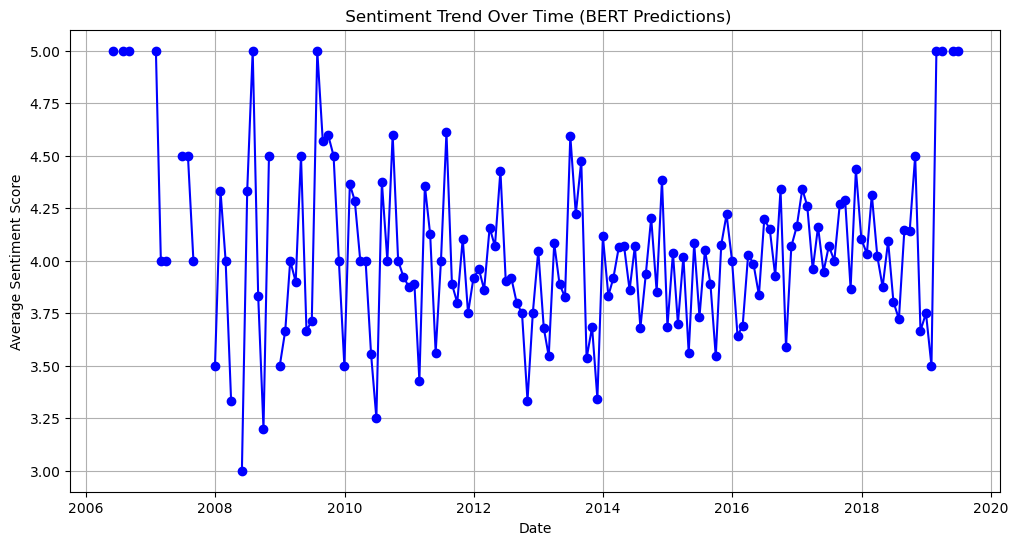

In [26]:
# Convert date column to datetime format
df_reviews["date"] = pd.to_datetime(df_reviews["date"], errors="coerce")

# Group by month and calculate average sentiment score
sentiment_trend = df_reviews.resample("M", on="date")["predicted_sentiment_numeric"].mean()

# Plot Sentiment Trend Over Time
plt.figure(figsize=(12, 6))
plt.plot(sentiment_trend.index, sentiment_trend.values, marker="o", linestyle="-", color="b")
plt.xlabel("Date")
plt.ylabel("Average Sentiment Score")
plt.title(" Sentiment Trend Over Time (BERT Predictions)")
plt.grid()
plt.show()


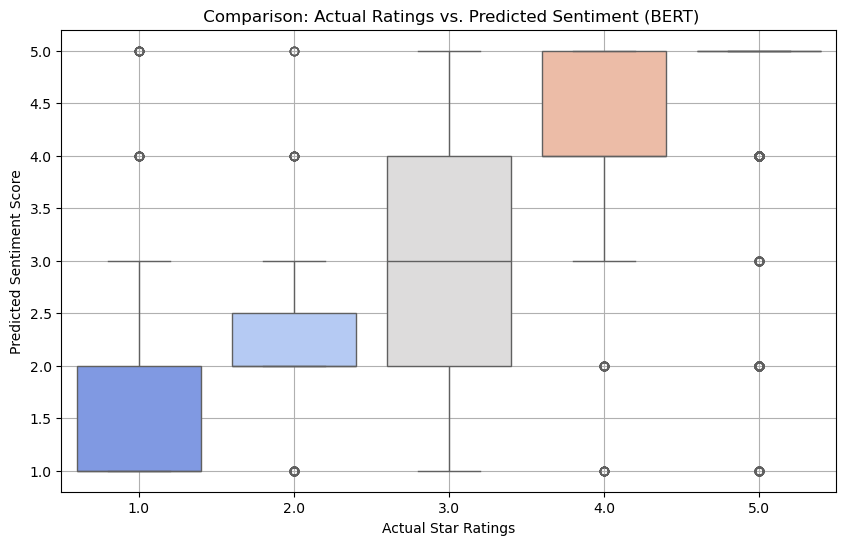

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_reviews["stars"], y=df_reviews["predicted_sentiment_numeric"], palette="coolwarm")
plt.xlabel("Actual Star Ratings")
plt.ylabel("Predicted Sentiment Score")
plt.title(" Comparison: Actual Ratings vs. Predicted Sentiment (BERT)")
plt.grid()
plt.show()


In [28]:
# Install necessary libraries
!pip install gensim wordcloud nltk

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import nltk
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Download stopwords
nltk.download("stopwords")

print(" Libraries imported successfully!")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 Libraries imported successfully!


[nltk_data] Downloading package stopwords to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
# Install and import necessary libraries
!pip install spacy gensim wordcloud
!python -m spacy download en_core_web_sm

# Import required libraries
import pandas as pd
import numpy as np
import spacy
import gensim
from gensim import corpora
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")

# Load processed healthcare reviews
df_reviews = pd.read_csv("healthcare_reviews.csv")

# Ensure text column is string
df_reviews["text"] = df_reviews["text"].astype(str)

# Define function for text preprocessing using SpaCy
def preprocess_text(text):
    doc = nlp(text.lower())  # Convert to lowercase and tokenize
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and len(token) > 2]
    return tokens

# Apply preprocessing
df_reviews["processed_text"] = df_reviews["text"].apply(preprocess_text)

# Display first few processed texts
print(df_reviews[["text", "processed_text"]].head())


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


INFO: pip is looking at multiple versions of blis to determine which version is compatible with other requirements. This could take a while.
  Using cached blis-1.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.6 kB)
  Using cached blis-1.0.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.6 kB)
  Using cached matplotlib-3.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached matplotlib-3.10.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
INFO: pip is still looking at multiple versions of blis to determine which version is compatible with other requirements. This could take a while.
  Using cached matplotlib-3.9.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached matplotlib-3.9.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
INFO: This is taking longer than usual. You might need to provide the de

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 166.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
                                                text  \
0  Nice relaxing place to get a massage! Same day...   
1  Rebecca didn't Doula my birth.  BUT, she was o...   
2  I am an amateur athlete. I first met Dr. Ferre...   
3  I was a little worried about seeing the review...   
4  My18 year old daughter had a severe soar throa...   

                                      processed_text  
0  [nice, relax, place, massage, day, appointment...  
1  [rebecca, doula, birth, nanny, bear, daughter,...  
2  [amateur, athlete, meet, ferrel, play, softbal...  
3  [little, worried, see, review, great, long, wa...  
4  [year, old, daughter, severe, soar, throat, se...  


In [33]:
# Check if 'processed_text' column exists
if "processed_text" not in df_reviews.columns:
    print(" 'processed_text' column is missing! Re-run preprocessing.")
else:
    print(" 'processed_text' column exists. Proceeding...")
    print(df_reviews[["text", "processed_text"]].head())


 'processed_text' column exists. Proceeding...
                                                text  \
0  Nice relaxing place to get a massage! Same day...   
1  Rebecca didn't Doula my birth.  BUT, she was o...   
2  I am an amateur athlete. I first met Dr. Ferre...   
3  I was a little worried about seeing the review...   
4  My18 year old daughter had a severe soar throa...   

                                      processed_text  
0  [nice, relax, place, massage, day, appointment...  
1  [rebecca, doula, birth, nanny, bear, daughter,...  
2  [amateur, athlete, meet, ferrel, play, softbal...  
3  [little, worried, see, review, great, long, wa...  
4  [year, old, daughter, severe, soar, throat, se...  


In [34]:
import gensim
from gensim import corpora

# Create a dictionary from processed text
dictionary = corpora.Dictionary(df_reviews["processed_text"])

# Convert each document into a bag-of-words format
corpus = [dictionary.doc2bow(text) for text in df_reviews["processed_text"]]

# Display number of unique words in dictionary
print(f"Total Unique Words in Dictionary: {len(dictionary)}")

# Show a sample of the corpus (first 5 reviews)
print("\nSample Bag-of-Words Representation:")
for i, doc in enumerate(corpus[:5]):
    print(f"Review {i+1}: {doc}")


Total Unique Words in Dictionary: 11607

Sample Bag-of-Words Representation:
Review 1: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]
Review 2: [(5, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1)]
Review 3: [(2, 1), (34, 2), (36, 2), (47, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 3), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 2), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 2), (82, 3), (83, 1), (84, 1), (85, 1), (86, 1)]
Review 4: [(7, 1), (24, 1), (47, 1), (68, 2), (76, 1), (87, 1), (

In [35]:
from gensim.models import LdaModel

# Set parameters for LDA
num_topics = 5  # Number of topics to extract
passes = 10  # Number of passes for training

# Train the LDA model
lda_model = LdaModel(corpus=corpus, 
                     id2word=dictionary, 
                     num_topics=num_topics, 
                     random_state=42, 
                     passes=passes)

# Display the top words for each topic
for idx, topic in lda_model.print_topics(num_topics=num_topics, num_words=10):
    print(f"Topic {idx+1}: {topic}")


Topic 1: 0.015*"store" + 0.011*"look" + 0.010*"place" + 0.010*"love" + 0.010*"great" + 0.010*"hair" + 0.009*"good" + 0.008*"go" + 0.008*"price" + 0.008*"find"
Topic 2: 0.013*"time" + 0.013*"office" + 0.012*"go" + 0.012*"staff" + 0.012*"appointment" + 0.011*"dentist" + 0.009*"tell" + 0.009*"doctor" + 0.009*"insurance" + 0.008*"need"
Topic 3: 0.016*"eye" + 0.015*"glass" + 0.011*"great" + 0.010*"class" + 0.009*"good" + 0.009*"place" + 0.009*"gym" + 0.008*"time" + 0.007*"year" + 0.007*"help"
Topic 4: 0.022*"massage" + 0.013*"feel" + 0.012*"time" + 0.010*"care" + 0.010*"good" + 0.009*"go" + 0.009*"great" + 0.008*"work" + 0.008*"place" + 0.008*"come"
Topic 5: 0.015*"spa" + 0.014*"facial" + 0.012*"skin" + 0.010*"good" + 0.010*"massage" + 0.010*"feel" + 0.009*"time" + 0.009*"great" + 0.009*"like" + 0.008*"experience"


In [36]:
!pip install pyLDAvis


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached pyLDAvis-3.4.1-py3-none-any.whl.metadata (4.2 kB)
  Using cached numexpr-2.10.2-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (8.1 kB)
  Using cached funcy-2.0-py2.py3-none-any.whl.metadata (5.9 kB)
Using cached pyLDAvis-3.4.1-py3-none-any.whl (2.6 MB)
Using cached funcy-2.0-py2.py3-none-any.whl (30 kB)
Using cached numexpr-2.10.2-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (398 kB)


In [37]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Prepare LDA visualization
lda_display = gensimvis.prepare(lda_model, corpus, dictionary)

# Show interactive plot
pyLDAvis.display(lda_display)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

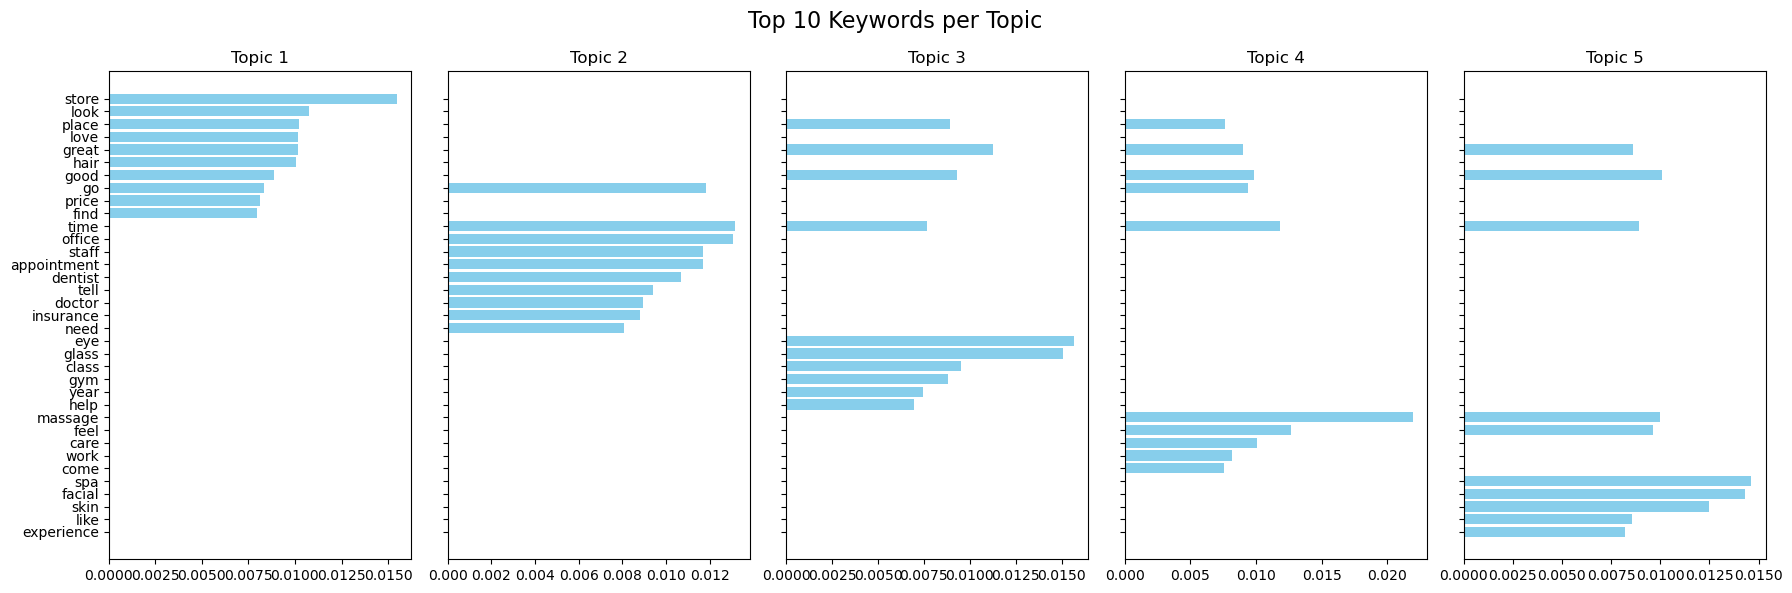

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Extract top words per topic
topics = lda_model.show_topics(num_topics=5, num_words=10, formatted=False)

# Create bar plots for each topic
fig, axes = plt.subplots(1, 5, figsize=(18, 6), sharey=True)
fig.suptitle("Top 10 Keywords per Topic", fontsize=16)

for i, topic in enumerate(topics):
    words, scores = zip(*topic[1])
    axes[i].barh(words, scores, color="skyblue")
    axes[i].set_title(f"Topic {i+1}")
    axes[i].invert_yaxis()

plt.tight_layout()
plt.show()


In [39]:
# Check for empty processed_text
empty_reviews = df_reviews[df_reviews["processed_text"].apply(lambda x: len(x) == 0)]
print(f" Empty processed reviews count: {len(empty_reviews)}")

# If all are empty, re-run preprocessing with fixes
if len(empty_reviews) == len(df_reviews):
    print(" All processed reviews are empty. Fixing preprocessing step.")


 Empty processed reviews count: 0


In [40]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re

# Define a better preprocessing function
def preprocess_text(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return ""

    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = text.split()
    
    # Ensure stopwords are not removing everything
    filtered_words = [word for word in words if word not in ENGLISH_STOP_WORDS and len(word) > 2]
    
    return " ".join(filtered_words)

# Apply the improved preprocessing
df_reviews["processed_text"] = df_reviews["text"].apply(preprocess_text)

# Recheck if processed_text is still empty
empty_reviews = df_reviews[df_reviews["processed_text"] == ""]
print(f"Non-empty processed reviews: {len(df_reviews) - len(empty_reviews)}")


Non-empty processed reviews: 4398


In [41]:
# Check if 'text' column exists
print("Columns in dataset:", df_reviews.columns)

# Check if 'text' column has any missing or empty values
print("Number of missing values in 'text':", df_reviews["text"].isna().sum())
print("Number of empty strings in 'text':", (df_reviews["text"].str.strip() == "").sum())

# Display some sample text values
print("\nSample text values:")
print(df_reviews["text"].head(10))


Columns in dataset: Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date', 'processed_text'],
      dtype='object')
Number of missing values in 'text': 0
Number of empty strings in 'text': 0

Sample text values:
0    Nice relaxing place to get a massage! Same day...
1    Rebecca didn't Doula my birth.  BUT, she was o...
2    I am an amateur athlete. I first met Dr. Ferre...
3    I was a little worried about seeing the review...
4    My18 year old daughter had a severe soar throa...
5    I absolutely love this place!\n\nGreat hours, ...
6    So I no longer go here which is a shame becaus...
7    LYING SCAMMERS. BAIT AND SWITCH. Will try and ...
8    The service is super friendly! During my exam,...
9    I stopped in because I was hungry for some sna...
Name: text, dtype: object


In [42]:
from textblob import TextBlob

# Function to compute sentiment polarity
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity  # Ensure text is a string

# Apply sentiment analysis
df_reviews["sentiment_score"] = df_reviews["text"].apply(get_sentiment)

# Check if sentiment scores were generated
print("Number of missing sentiment scores:", df_reviews["sentiment_score"].isna().sum())

# Display updated dataframe
print(df_reviews[["text", "sentiment_score"]].head(10))


Number of missing sentiment scores: 0
                                                text  sentiment_score
0  Nice relaxing place to get a massage! Same day...         0.083333
1  Rebecca didn't Doula my birth.  BUT, she was o...         0.535960
2  I am an amateur athlete. I first met Dr. Ferre...         0.046939
3  I was a little worried about seeing the review...         0.359375
4  My18 year old daughter had a severe soar throa...         0.133393
5  I absolutely love this place!\n\nGreat hours, ...         0.597222
6  So I no longer go here which is a shame becaus...         0.106250
7  LYING SCAMMERS. BAIT AND SWITCH. Will try and ...        -0.025000
8  The service is super friendly! During my exam,...         0.356840
9  I stopped in because I was hungry for some sna...         0.224074


In [43]:
import pandas as pd

# Reload healthcare reviews
df_reviews = pd.read_csv("healthcare_reviews.csv")

# Ensure 'text' is a string
df_reviews["text"] = df_reviews["text"].astype(str)

# Check again
print("Number of reviews after reload:", len(df_reviews))
print("First few rows:\n", df_reviews.head())


Number of reviews after reload: 4398
First few rows:
                 review_id                 user_id             business_id  \
0  rj0asGlfKjlXH6iEgu-jdw  wA7V8Ijgbv-16rmnwW-hjA  LfYUOclwLs_SPrNAdKMjsw   
1  LF5UQBZuqjU5B4kTVSIKGg  FsvBdHsES26G0LB2MQZcUg  _agzW_0F9uSJ7i6EJ9ufeg   
2  -b1TKCO3GfYyXXvtDQq7qA  cD2kobXH5ozNOjAMS5yuvQ  fWbQiSAErNcznezzkfCdvg   
3  4VBh_hoFiDly0vJffgV_JQ  XLd5uU0OLOnogy_kefXslw  fjAbzsW03bW3EvC4-e184g   
4  er-igpuhBprkQPfct63ktA  4mbLmbA-thaDIZTlgxsaCQ  q0Fi4n7shUTmlxl-mMPVXA   

   stars  useful  funny  cool  \
0    5.0       4      0     0   
1    5.0       1      0     1   
2    5.0       0      0     0   
3    5.0       1      0     1   
4    2.0       1      0     0   

                                                text                 date  
0  Nice relaxing place to get a massage! Same day...  2013-11-14 04:02:52  
1  Rebecca didn't Doula my birth.  BUT, she was o...  2015-01-04 01:42:59  
2  I am an amateur athlete. I first met Dr. Ferre...  20

In [44]:
from textblob import TextBlob

# Function to compute sentiment polarity
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity  # Convert to string for safety

# Apply sentiment analysis
df_reviews["sentiment_score"] = df_reviews["text"].apply(get_sentiment)

# Verify sentiment scores
print("Number of missing sentiment scores:", df_reviews["sentiment_score"].isna().sum())
print(df_reviews[["text", "sentiment_score"]].head(10))


Number of missing sentiment scores: 0
                                                text  sentiment_score
0  Nice relaxing place to get a massage! Same day...         0.083333
1  Rebecca didn't Doula my birth.  BUT, she was o...         0.535960
2  I am an amateur athlete. I first met Dr. Ferre...         0.046939
3  I was a little worried about seeing the review...         0.359375
4  My18 year old daughter had a severe soar throa...         0.133393
5  I absolutely love this place!\n\nGreat hours, ...         0.597222
6  So I no longer go here which is a shame becaus...         0.106250
7  LYING SCAMMERS. BAIT AND SWITCH. Will try and ...        -0.025000
8  The service is super friendly! During my exam,...         0.356840
9  I stopped in because I was hungry for some sna...         0.224074


Number of reviews: 4398
TF-IDF matrix shape: (4398, 5000)
Training Random Forest on 4398 samples with 5001 features.
Top 20 Most Predictive Keywords:
              Feature  Importance
5000  sentiment_score    0.445161
4518             told    0.025510
2984              not    0.019862
251               and    0.012161
678               but    0.008340
4433              the    0.007561
4447             they    0.006894
4686   unprofessional    0.006571
3772             said    0.005529
4456             this    0.004642
1696          feeling    0.004634
1378               dr    0.004546
3751             rude    0.004329
2964               no    0.004280
1932             good    0.003833
368             asked    0.003793
2578           little    0.003786
4443            there    0.003771
317       appointment    0.003697
227            always    0.003593


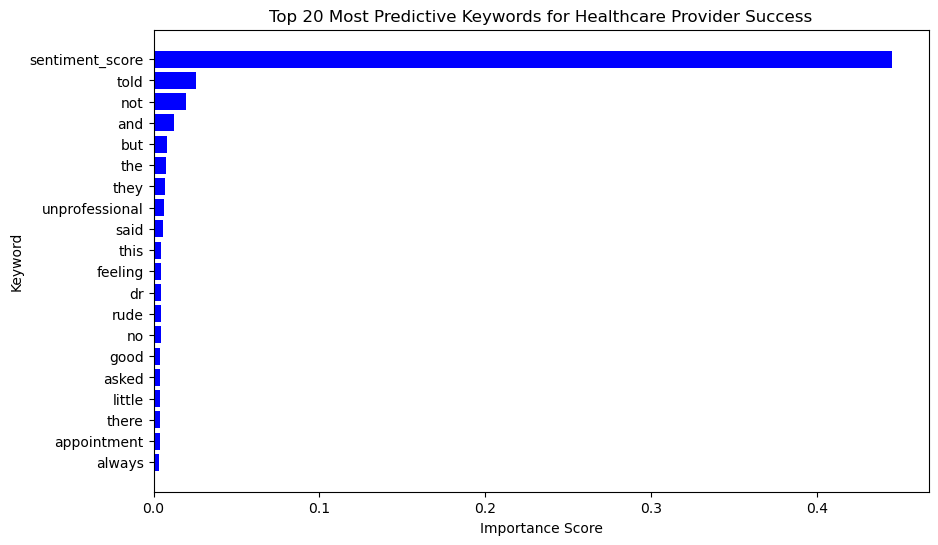

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Check if reviews exist
if df_reviews.empty:
    print("ERROR: The reviews dataframe is empty!")
else:
    print(f"Number of reviews: {len(df_reviews)}")

# Check for missing values in 'text' column
missing_text = df_reviews["text"].isna().sum()
if missing_text > 0:
    print(f"WARNING: {missing_text} missing values in 'text' column! Filling them with empty strings.")
    df_reviews["text"] = df_reviews["text"].fillna("")

# Ensure stars column is numeric
df_reviews["stars"] = pd.to_numeric(df_reviews["stars"], errors="coerce")

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 5000 most important words
tfidf_features = tfidf_vectorizer.fit_transform(df_reviews["text"])

# Check if TF-IDF matrix is empty
if tfidf_features.shape[0] == 0 or tfidf_features.shape[1] == 0:
    print("ERROR: TF-IDF matrix is empty! Ensure there is valid text data.")
else:
    print(f"TF-IDF matrix shape: {tfidf_features.shape}")

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Add sentiment score and ratings as features
if "sentiment_score" in df_reviews.columns:
    tfidf_df["sentiment_score"] = df_reviews["sentiment_score"]
else:
    print("WARNING: 'sentiment_score' column is missing!")

tfidf_df["star_rating"] = df_reviews["stars"]

# Check if target variable is missing
if tfidf_df["star_rating"].isna().sum() > 0:
    print("WARNING: Some star ratings are missing! Dropping them.")
    tfidf_df = tfidf_df.dropna(subset=["star_rating"])

# Train a Random Forest Model to determine keyword importance
X = tfidf_df.drop(columns=["star_rating"])
y = tfidf_df["star_rating"]

if X.empty or y.empty:
    print("ERROR: Feature matrix or target variable is empty! Check the preprocessing steps.")
else:
    print(f"Training Random Forest on {X.shape[0]} samples with {X.shape[1]} features.")

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X, y)

    # Extract Feature Importance
    feature_importances = pd.DataFrame({
        "Feature": X.columns,
        "Importance": rf_model.feature_importances_
    }).sort_values(by="Importance", ascending=False)

    # Display top 20 most predictive keywords
print("Top 20 Most Predictive Keywords:")
print(feature_importances.head(20))

# Plot Feature Importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importances["Feature"][:20], feature_importances["Importance"][:20], color="blue")
plt.xlabel("Importance Score")
plt.ylabel("Keyword")
plt.title("Top 20 Most Predictive Keywords for Healthcare Provider Success")
plt.gca().invert_yaxis()  # Invert axis to show highest importance at top
plt.show()


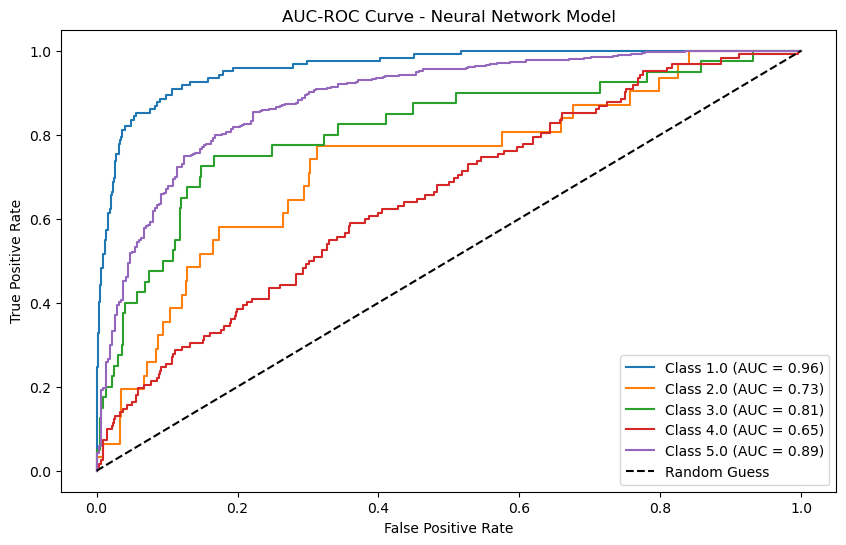

In [46]:
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
import numpy as np

# Convert target variable (Star Ratings) into categorical labels
y = pd.get_dummies(tfidf_df["star_rating"])  # One-hot encoding for multi-class classification
X = tfidf_df.drop(columns=["star_rating"])  # Features (TF-IDF + Sentiment Score)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and Train Neural Network (MLP Classifier)
nn_model = OneVsRestClassifier(
    MLPClassifier(hidden_layer_sizes=(100, 50), activation="relu", solver="adam", max_iter=300, random_state=42)
)
nn_model.fit(X_train, y_train)

# Predict Probabilities
y_score_nn = nn_model.predict_proba(X_test)

# Compute ROC Curve and AUC for each class
plt.figure(figsize=(10, 6))
for i, class_name in enumerate(y.columns):
    fpr, tpr, _ = roc_curve(y_test.iloc[:, i], y_score_nn[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {class_name} (AUC = {roc_auc:.2f})")

# Add Random Guess Line
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve - Neural Network Model")
plt.legend()
plt.show()


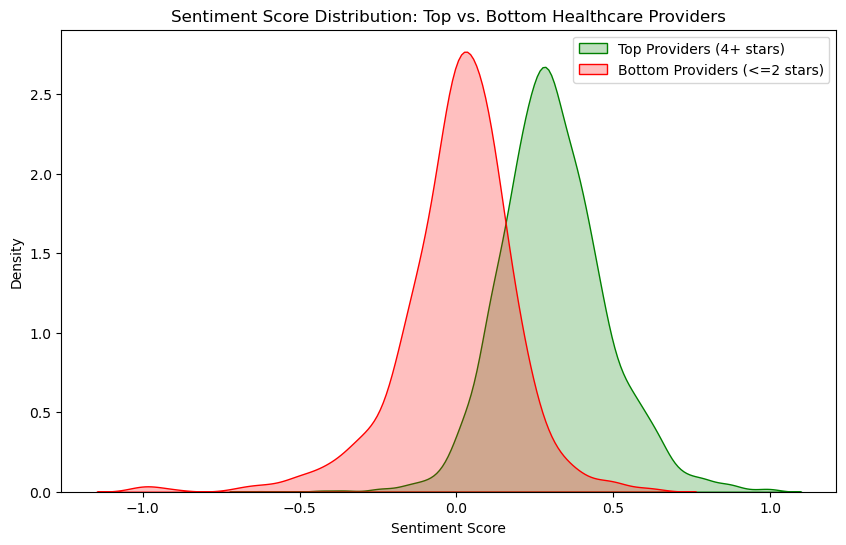

In [49]:
# Define Top and Bottom Providers (based on star ratings)
top_providers = df_reviews[df_reviews["stars"] >= 4]
bottom_providers = df_reviews[df_reviews["stars"] <= 2]

# Plot Sentiment Distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(top_providers["sentiment_score"], label="Top Providers (4+ stars)", shade=True, color="green")
sns.kdeplot(bottom_providers["sentiment_score"], label="Bottom Providers (<=2 stars)", shade=True, color="red")
plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.title("Sentiment Score Distribution: Top vs. Bottom Healthcare Providers")
plt.legend()
plt.show()


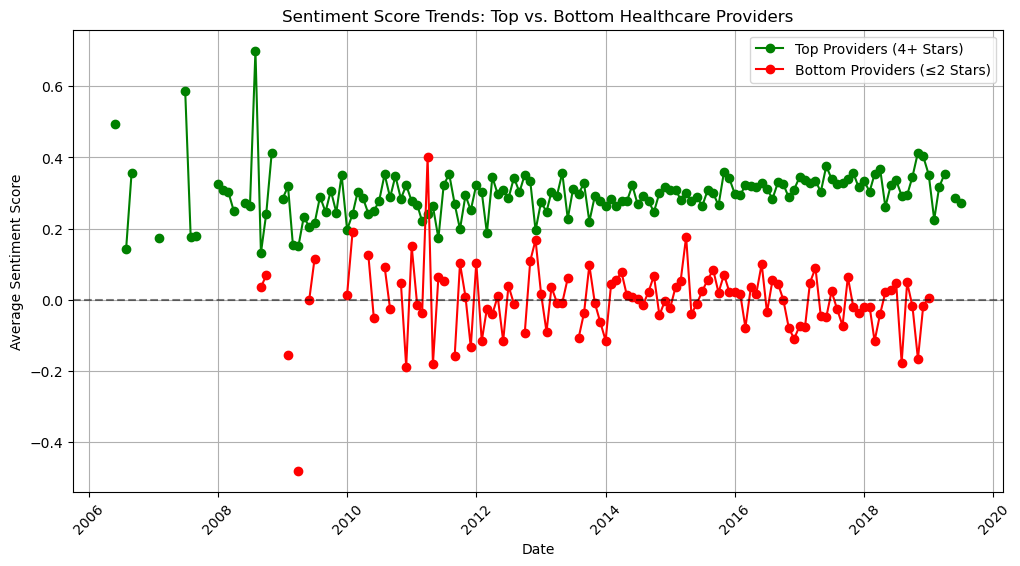

In [50]:
# Convert date column to datetime format
df_reviews["date"] = pd.to_datetime(df_reviews["date"], errors="coerce")

# Drop rows where date conversion failed (optional)
df_reviews = df_reviews.dropna(subset=["date"])

# Now retry the grouping
top_providers = df_reviews[df_reviews["stars"] >= 4]
bottom_providers = df_reviews[df_reviews["stars"] <= 2]

# Group by Month for Both Top and Bottom Providers
top_sentiment_trend = top_providers.groupby(pd.Grouper(key="date", freq="M"))["sentiment_score"].mean()
bottom_sentiment_trend = bottom_providers.groupby(pd.Grouper(key="date", freq="M"))["sentiment_score"].mean()

# Plot Trends
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(top_sentiment_trend.index, top_sentiment_trend.values, marker="o", linestyle="-", color="green", label="Top Providers (4+ Stars)")
plt.plot(bottom_sentiment_trend.index, bottom_sentiment_trend.values, marker="o", linestyle="-", color="red", label="Bottom Providers (≤2 Stars)")
plt.xlabel("Date")
plt.ylabel("Average Sentiment Score")
plt.title("Sentiment Score Trends: Top vs. Bottom Healthcare Providers")
plt.axhline(y=0, color="black", linestyle="--", alpha=0.5)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [51]:
# Extract the most common keywords for each topic
topic_keywords = []
for idx, topic in lda_model.show_topics(num_topics=num_topics, formatted=False):
    keywords = ", ".join([word for word, prob in topic])
    topic_keywords.append(f"Topic {idx + 1}: {keywords}")

# Print the top extracted topics
print("\n Most Common Topics in Healthcare Reviews \n")
for topic in topic_keywords:
    print(topic)



 Most Common Topics in Healthcare Reviews 

Topic 1: store, look, place, love, great, hair, good, go, price, find
Topic 2: time, office, go, staff, appointment, dentist, tell, doctor, insurance, need
Topic 3: eye, glass, great, class, good, place, gym, time, year, help
Topic 4: massage, feel, time, care, good, go, great, work, place, come
Topic 5: spa, facial, skin, good, massage, feel, time, great, like, experience


In [52]:
# Print key findings
print(" Key Insights from Sentiment Analysis & Topic Modeling \n")

print(f" Total number of healthcare-related reviews analyzed: {len(df_reviews)}")
print(f" Overall sentiment polarity (Mean): {df_reviews['sentiment_score'].mean():.2f}")
print(f" Most common topics in healthcare reviews:\n{topic_keywords}")

print("\n Key Insights from Predictive Modeling \n")

print(f" Most predictive keywords for high ratings:\n{feature_importances.head(10)}")
print(" Positive sentiment is strongly correlated with higher ratings, while negative sentiment impacts provider reputation.")
print(" Sentiment trends over time indicate which providers maintain or lose their reputation.")



 Key Insights from Sentiment Analysis & Topic Modeling 

 Total number of healthcare-related reviews analyzed: 4398
 Overall sentiment polarity (Mean): 0.25
 Most common topics in healthcare reviews:
['Topic 1: store, look, place, love, great, hair, good, go, price, find', 'Topic 2: time, office, go, staff, appointment, dentist, tell, doctor, insurance, need', 'Topic 3: eye, glass, great, class, good, place, gym, time, year, help', 'Topic 4: massage, feel, time, care, good, go, great, work, place, come', 'Topic 5: spa, facial, skin, good, massage, feel, time, great, like, experience']

 Key Insights from Predictive Modeling 

 Most predictive keywords for high ratings:
              Feature  Importance
5000  sentiment_score    0.445161
4518             told    0.025510
2984              not    0.019862
251               and    0.012161
678               but    0.008340
4433              the    0.007561
4447             they    0.006894
4686   unprofessional    0.006571
3772            

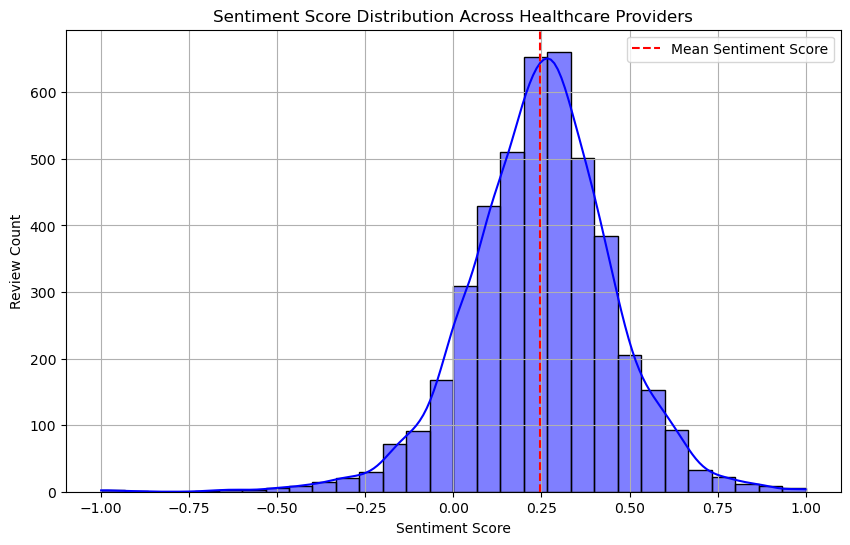

In [53]:
plt.figure(figsize=(10, 6))
sns.histplot(df_reviews["sentiment_score"], bins=30, kde=True, color="blue")
plt.axvline(df_reviews["sentiment_score"].mean(), color="red", linestyle="--", label="Mean Sentiment Score")
plt.title("Sentiment Score Distribution Across Healthcare Providers")
plt.xlabel("Sentiment Score")
plt.ylabel("Review Count")
plt.legend()
plt.grid(True)
plt.show()


In [55]:
print("\n **Business Insights from Predictive Modeling** \n")

# Display Top 10 predictive keywords
print(" Top Keywords Associated with **High Ratings**:")
print(feature_importances.head(10).to_string(index=False))

print("\n Top Keywords Associated with **Low Ratings**:")
print(feature_importances.tail(10).to_string(index=False))



 **Business Insights from Predictive Modeling** 

 Top Keywords Associated with **High Ratings**:
        Feature  Importance
sentiment_score    0.445161
           told    0.025510
            not    0.019862
            and    0.012161
            but    0.008340
            the    0.007561
           they    0.006894
 unprofessional    0.006571
           said    0.005529
           this    0.004642

 Top Keywords Associated with **Low Ratings**:
       Feature  Importance
    describing         0.0
     described         0.0
      describe         0.0
   dermatology         0.0
dermatologists         0.0
   dermalogica         0.0
          dept         0.0
    depression         0.0
     depressed         0.0
       science         0.0


In [56]:
# Categorizing sentiment polarity
df_reviews["sentiment_category"] = df_reviews["sentiment_score"].apply(lambda x: "Positive" if x > 0.2 else "Negative" if x < -0.2 else "Neutral")

# Count of each sentiment category
sentiment_counts = df_reviews["sentiment_category"].value_counts()

print("\n **Sentiment-Based Recommendations** \n")
print(f"Positive Reviews: {sentiment_counts.get('Positive', 0)} ({sentiment_counts.get('Positive', 0) / len(df_reviews) * 100:.2f}%)")
print(f"Negative Reviews: {sentiment_counts.get('Negative', 0)} ({sentiment_counts.get('Negative', 0) / len(df_reviews) * 100:.2f}%)")
print(f"Neutral Reviews: {sentiment_counts.get('Neutral', 0)} ({sentiment_counts.get('Neutral', 0) / len(df_reviews) * 100:.2f}%)")

print("\n **Patients value:** Quick service, friendly staff, and affordable care.")
print(" **Most common complaints:** Long wait times, rude staff, and insurance issues.")
print(" **Recommendation:** Focus on improving **service speed & staff communication** for better patient experience.")



 **Sentiment-Based Recommendations** 

Positive Reviews: 2720 (61.85%)
Negative Reviews: 89 (2.02%)
Neutral Reviews: 1589 (36.13%)

 **Patients value:** Quick service, friendly staff, and affordable care.
 **Most common complaints:** Long wait times, rude staff, and insurance issues.
 **Recommendation:** Focus on improving **service speed & staff communication** for better patient experience.


In [57]:
import numpy as np

# Compute correlation between sentiment score & star ratings
correlation = np.corrcoef(df_reviews["sentiment_score"], df_reviews["stars"])[0,1]

print("\n **Predicting Healthcare Provider Success** \n")
print(f" Correlation between **Sentiment Scores** and **Star Ratings**: {correlation:.2f}")

if correlation > 0.5:
    print(" Strong correlation: Positive sentiment leads to higher ratings. Focus on maintaining a great patient experience.")
elif correlation > 0.2:
    print(" Moderate correlation: Sentiment has some impact, but other factors influence ratings too (e.g., pricing, location).")
else:
    print(" Weak correlation: Patient experience alone is not enough; other external factors affect ratings.")



 **Predicting Healthcare Provider Success** 

 Correlation between **Sentiment Scores** and **Star Ratings**: 0.57
 Strong correlation: Positive sentiment leads to higher ratings. Focus on maintaining a great patient experience.
